# Run Monte Carlo Simulation in Brightway

Now we are ready to start doing more intense simulations. In particular Brightway is great to perform fast error propagation with Monte Carlo simulation. 

This script shows how to add uncertainties to your home-made product system and run a Monte Carlo simulation. 

To better understand this script, I recommend reading read Limpert et al. (2001) that explains the log-normal distribution.

_Limpert, E., Stahel, W. A., & Abbt, M. (2001). Log-normal distributions across the sciences: Keys and clues. Bioscience, 51(5), 341-352. [https://doi.org/10.1641/0006-3568(2001)051[0341:LNDATS]2.0.CO;2](https://academic.oup.com/bioscience/article/51/5/341/243981)_

A very useful resource is the book: _Heijungs, R. (2024). Probability, Statistics and Life Cycle Assessment: Guidance for Dealing with Uncertainty and Sensitivity. Springer International Publishing. [https://doi.org/10.1007/978-3-031-49317-1](https://link.springer.com/book/10.1007/978-3-031-49317-1)_


In [4]:
# Import brightway2.5 packages
import bw2calc as bc
import bw2data as bd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [5]:
bd.projects.set_current('advlca25')

In [6]:
bd.databases

Databases dictionary with 5 object(s):
	ecoinvent-3.11-biosphere
	ecoinvent-3.11-consequential
	exldb
	testbiosphere
	testdb

A short recap, let's create a foreground database and run LCA calculations

In [8]:
t_db = bd.Database('testdb')

t_db.write({  # A simplified version, only CO2 as emission
    ('testdb', 'Electricity production'): {
        'name': 'Electricity production',
        'unit': 'kWh',
        'location': 'GLO',
        'exchanges': [{
                'input': ('testdb', 'Fuel production'),
                'amount': -2,
                'unit': 'kg',
                'type': 'technosphere'
            }, {
                'input': ('testdb', 'Carbon dioxide'),
                'amount': 1,
                'unit': 'kg',
                'type': 'biosphere'
            }, {
                'input': ('testdb', 'Electricity production'),
                'amount': 10,
                'unit': 'kWh',
                'type': 'production'
            }]
        },
    ('testdb', 'Fuel production'): {
        'name': 'Fuel production',
        'unit': 'kg',
        'location': 'GLO',
        'exchanges': [{
                'input': ('testdb', 'Carbon dioxide'),
                'amount': 10,
                'unit': 'kg',
                'type': 'biosphere'
            }, {
                'input': ('testdb', 'Fuel production'),
                'amount': 100,
                'unit': 'kg',
                'type': 'production'
            }]
    },
    ('testdb', 'Carbon dioxide'): {'name': 'Carbon dioxide', 'unit': 'kg', 'type': 'biosphere'}
    })


myLCIAdata = [[('testdb', 'Carbon dioxide'), 1.0]]
method_key = ('simplemethod', 'imaginaryendpoint', 'imaginarymidpoint')
my_method = bd.Method(method_key)
my_method.validate(myLCIAdata)
my_method.register()
my_method.write(myLCIAdata)
my_method.load()

functional_unit = {t_db.get('Electricity production'): 1000}
lca = bc.LCA(functional_unit, method_key)  # LCA calculations with method
lca.lci()
lca.lcia()

100%|██████████████████████████████████████████| 3/3 [00:00<00:00, 20036.48it/s]

13:45:35 [info     ] Vacuuming database            


In [9]:
print(lca.score) 

80.0


What is important here is that 80.0 is the **nominal** value (other places called *static* or *deterministic* , see Heijungs R. (2024), chapter 10.1.11 for more info). In pragmatic terms, this is the result of the LCA without considering uncertainties, what 99.9% of LCA studies usually report. We need to remember that for later.

# Now add uncertainty 

See a tutorial [here](http://nbviewer.jupyter.org/urls/bitbucket.org/cmutel/brightway2/raw/default/notebooks/Activities%20and%20exchanges.ipynb)

**Note**: uncertainties are always added to **exchanges** (not to activities...)

So I'll get one  exchange from one activity

In [10]:
el = t_db.get('Electricity production')  
co2_exc = list(el.exchanges())[1]   # the first exchange
co2_exc

Exchange: 1 kg 'Carbon dioxide' (kg, None, None) to 'Electricity production' (kWh, GLO, None)>

In [11]:
# Lognormal distribution first
from stats_arrays import LognormalUncertainty
import numpy as np
co2_exc['uncertainty type'] = LognormalUncertainty.id # this is an integer (not a float)
co2_exc['loc'], co2_exc['scale'] = np.log(co2_exc['amount']), np.log(1.01) 
'''The lognorm dist is defined here two parameters: location and scale 
i.e. by the log of the geometric mean and by the geometric standard dev'''
co2_exc.save() # important

In [12]:
el = t_db.get('Electricity production')  
fuel_exc = list(el.exchanges())[0]   # the first exchange
fuel_exc

Exchange: -2 kg 'Fuel production' (kg, GLO, None) to 'Electricity production' (kWh, GLO, None)>

In [13]:
# Lognormal distribution first
from stats_arrays import LognormalUncertainty
import numpy as np
fuel_exc['uncertainty type'] = LognormalUncertainty.id # this is an integer (not a float)
fuel_exc['loc'], fuel_exc['scale'] = np.log(-fuel_exc['amount']), np.log(1.01)
fuel_exc['negative'] = True
'''The lognorm dist is defined here two parameters: location and scale 
i.e. by the log of the geometric mean and by the geometric standard dev'''
fuel_exc.save() # important

In [14]:
fuel_exc.uncertainty  #

{'uncertainty type': 2,
 'loc': 0.6931471805599453,
 'scale': 0.009950330853168092,
 'negative': True}

In [15]:
co2_exc.uncertainty  # check that info is stored

{'uncertainty type': 2, 'loc': 0.0, 'scale': 0.009950330853168092}

In [16]:
co2_exc.as_dict()  # Now uncertainty is included

{'input': ('testdb', 'Carbon dioxide'),
 'amount': 1,
 'unit': 'kg',
 'type': 'biosphere',
 'output': ('testdb', 'Electricity production'),
 'uncertainty type': 2,
 'loc': 0.0,
 'scale': 0.009950330853168092}

In [17]:
co2_exc.random_sample(n=10)  # nice

array([1.00339645, 0.99368596, 1.00464956, 1.02934388, 0.99217568,
       0.98216102, 0.99962787, 0.99791392, 0.99711758, 1.00076325])

(array([ 17.,  50., 122., 195., 243., 166., 127.,  53.,  16.,  11.]),
 array([0.97432932, 0.98010153, 0.98587375, 0.99164596, 0.99741817,
        1.00319038, 1.0089626 , 1.01473481, 1.02050702, 1.02627923,
        1.03205145]),
 <BarContainer object of 10 artists>)

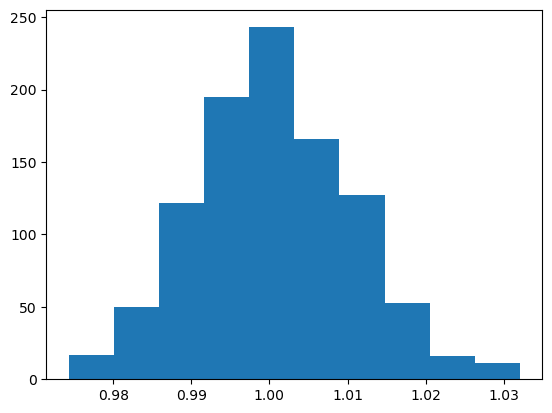

In [18]:
# if you want to see this
%matplotlib inline
plt.hist(co2_exc.random_sample(n=1000))

In [19]:
# this in case you want to try with normal dist
#from stats_arrays import NormalUncertainty

#co2_exc['uncertainty type'] = NormalUncertainty.id
#co2_exc['loc'], co2_exc['scale'] = 1, 0.01
#co2_exc.save()
#co2_exc.uncertainty  # check that
#co2_exc.as_dict()  # OK

#  Now MC simulation

In [20]:
# Check again that uncertainty info is stored
list(el.exchanges())[0].uncertainty

{'uncertainty type': 2,
 'loc': 0.6931471805599453,
 'scale': 0.009950330853168092,
 'negative': True}

In [21]:
bd.methods

Methods dictionary with 634 objects, including:
	('ecoinvent-3.11', 'CML v4.8 2016', 'acidification', 'acidification (incl. fate, average Europe total, A&B)')
	('ecoinvent-3.11', 'CML v4.8 2016', 'climate change', 'global warming potential (GWP100)')
	('ecoinvent-3.11', 'CML v4.8 2016', 'ecotoxicity: freshwater', 'freshwater aquatic ecotoxicity (FAETP inf)')
	('ecoinvent-3.11', 'CML v4.8 2016', 'ecotoxicity: marine', 'marine aquatic ecotoxicity (MAETP inf)')
	('ecoinvent-3.11', 'CML v4.8 2016', 'ecotoxicity: terrestrial', 'terrestrial ecotoxicity (TETP inf)')
	('ecoinvent-3.11', 'CML v4.8 2016', 'energy resources: non-renewable', 'abiotic depletion potential (ADP): fossil fuels')
	('ecoinvent-3.11', 'CML v4.8 2016', 'eutrophication', 'eutrophication (fate not incl.)')
	('ecoinvent-3.11', 'CML v4.8 2016', 'human toxicity', 'human toxicity (HTP inf)')
	('ecoinvent-3.11', 'CML v4.8 2016', 'material resources: metals/minerals', 'abiotic depletion potential (ADP): elements (ultimate reserve

#### Note: the way MC simulation is run in bw2.5 is slightly divverent than in bw2

In [22]:
# This is the montecarlo simulation
mc = bc.LCA(demand={el: 1000}, method=method_key, use_distributions=True)
mc.lci()
mc.lcia()
mc_results = [mc.score for _ in zip(range(500), mc)] # this is a different way of calling the mc than in bw2

# two things here:
# 1. zip() returns a zip object, which is an iterator of tuples, for instance:
    # a = (1, 2, 3)
    # b = ('a', 'b', 'c')
    # for i in zip(a, b):
    #     print(i) 
    # # output will be: 
    #     # (1, 'a')
    #     # (2, 'b')
    #     # (3, 'c')

# 2. using a fuction within [ ] usig a for loop is called a "list comprehension". The result is a list

In [29]:
mc_results[1:10] # printing the first 10 elements on the list...remember, the nominal value was 80

[80.14099136625978,
 79.83396643721692,
 81.2425363213552,
 81.5300470667447,
 82.2117870314039,
 81.47626177661199,
 79.86273487049584,
 79.44255239513294,
 80.7378207473873]

Text(0.5, 0, 'lca.score')

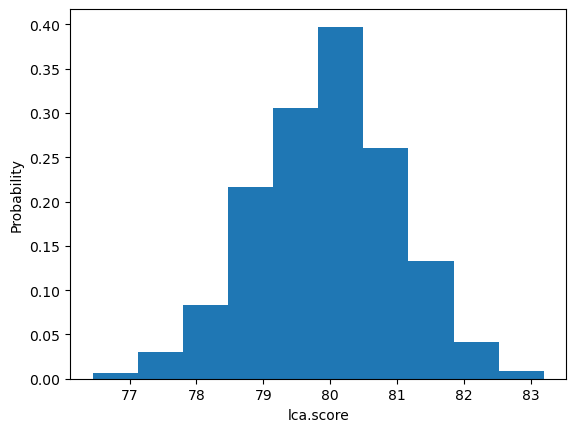

In [28]:
# Look at the MC results, what you see is the sample distribution
plt.hist(mc_results, density=True)  # From matplotlib package. Use bins = int(500/15) to increase number of bars
plt.ylabel("Probability")
plt.xlabel('lca.score')

In [26]:
print(np.mean(mc_results)) # from numpy package
print(np.median(mc_results)) # from numpy package
print(lca.score) # the nominal value, we are very close to the mean and median

79.9560820274774
80.00510777247528
80.0


In [27]:
pd.DataFrame(mc_results).describe()  # useful descriptive stats from pandas package

,0
count,500.000000
mean,79.956082
std,1.064236
min,76.449207
25%,79.266880
50%,80.005108
75%,80.682538
max,83.194571


Text(0.5, 0, 'lca.score')

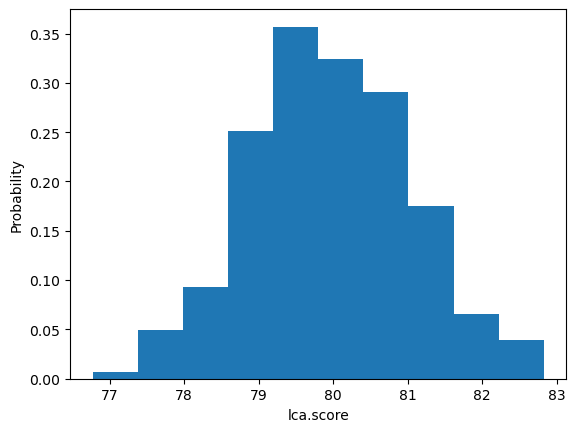

In [30]:
# Do this again and compare results
mc2 = bc.LCA(demand={el: 1000}, method=method_key, use_distributions=True)
mc.lci()
mc.lcia()
mc2_results = [mc.score for _ in zip(range(500), mc)]

plt.hist(mc2_results, density=True)
plt.ylabel("Probability")
plt.xlabel('lca.score')

In [31]:
print(np.mean(mc2_results))
print(np.median(mc2_results))
print(lca.score)

79.96936771759405
79.92675260080452
80.0


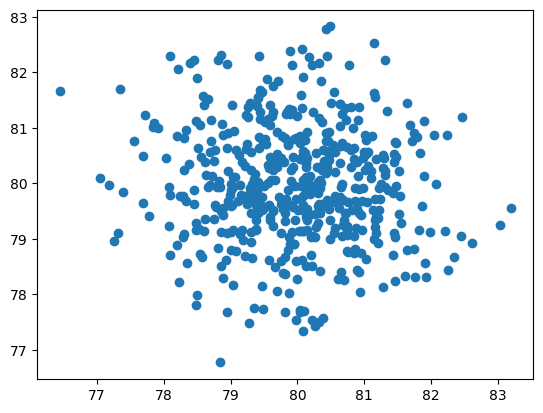

In [32]:
plt.scatter(mc_results, mc2_results) # Correct. Do you understand why? 

#(there is no relation because the two distributions are independent. We see an indistinct "cloud" and no pattern)

In [33]:
# Another way to do it
iterations = 1000
scores = np.zeros(iterations)  # 1-dimensional array filled with zeros
for iteration in range(iterations):
    next(mc)
    scores[iteration] = mc.score
for i in range(1, 10):
    print(scores[i])  # need the zero because one-dimensional array

80.91837111685935
80.33321751239643
79.550043899189
80.94978243621046
78.86091973389834
77.59528202296718
79.83724796816496
80.07113681466508
80.97058559607245


In [34]:
# Another way, get a list instead of an array
iterations = 1000
scores = []
for iteration in range(iterations):
    next(mc)
    scores.append(mc.score)
for i in range(1, 10):
    print(scores[i])
type(scores) == type(mc_results)  # same type of results as in the first case

78.99362583385826
80.1905575381033
78.53038682865625
81.08476287993349
79.36656160579197
79.13223899840034
79.74451255191889
79.4861634057659
79.87955412346459


True